# COVID-19 Contact Networks



## Import Packages 

First we import all required Python packages that we need during the project. 

In [ ]:
 # the pandas package provides tools for storing and manipulating dataframes
import pandas as pd       
# numpy package for working with arrays of numbers 
import numpy as np       
# import matplotlib.pyplot package for functions to plot numeric data
import matplotlib.pyplot as plt   
# import "os" package which provides methods for using filesystem
import os                          
# import "networkx" package which provides methods for generating and processing networks
import networkx as nx              
# import "datetime" package which provides methods to process date and time strings
import datetime as dt           
# import "geopy" package which provides methods to process geographic coordinates
from geopy.distance import geodesic   
# import "sklearn" package which provides methods for processing label values
import sklearn as sk
#import module "preprocessing" from package "sklearn"
from sklearn import preprocessing

## Step 1 - Generate Contact Network

In this step, the "PeopleLocations.csv" is read in as a pandas dataframe, which contains a list of recorded locations of individiuals at specific times. Each individual has a unique identifier (ID), and corresponding latitude (Latidute), longitude(Longitude), date(Date) and time(Time) at which the recording was taken. Thus the dataframe contains the features:  

`ID; Latidute; Longitude; Date; Time; Covid19`

Here `ID` is a string that represents the identifier of the individual. The fields `Latitude` and `Longitude`are GPS coordinates of the individual at the time of recording. The fields `Date` and `Time` are strings representing the date and time of the recording. The last field `Covid19` contains `"y"` if the individual has been found Covid-19 positive at the time of recording. Otherwise the field `Covid19` contains `"n"`. 

In [ ]:
# read in data from PeopleLocations.csv into dataframe "df"
peloc = pd.read_csv('PeopleLocations.csv',sep=';')    

# store the header of the first colum of dataframe df in variable "IDcol"

IDcol = peloc.columns[0]

# determine a list of different individuals for which there is at least one record in the csv file

uniquepart = peloc[IDcol].unique()       

# count the number of different individuals. this will be the number of nodes in the contace network

nrnodes = len(uniquepart)        

In [ ]:
# build up the network by adding a node for each individual with a record in "PeopleLocations.csv"

# create an object "G" using the constructor nx.Graph() 

G = nx.Graph()

# create object "le" of class preprocessing.LabelEncoder() 
# the object "le" will be used to transfrom values 'y' or 'n' for the attribue "Covid19" to values 1 or 0

le = preprocessing.LabelEncoder()               

# use function le.fit() to define the label values "n" and "y" to be mapped to 0 and 1 

le.fit(["n", "y"])

# iterate over different individuals indexed by nodeidx=0,1,...

for nodeidx in range(nrnodes): 
    
    # read in identifier of individual from list `uniquepart` and store in variable personid
    personid = uniquepart[nodeidx]
    
    # create dataframe dmydf by selecting all rows from dataframe `df` with attribute `ID` equal to `personid`
    dmydf = pd.DataFrame(df.loc[df['ID'] == personid].copy())
    
    # reset index of dataframe dmydf
    dmydf.reset_index(drop=True, inplace=True) 
    
    # read in latitude of first location recording in `dmydf` and store in variable `latitude`
    latitude=dmydf.loc[0,['Lat']][0]
    
    # read in longitude of first location recording in `dmydf` and store in variable `longitude`
    longitude=dmydf.loc[0,['Lon']][0]
    
    # read in Covid19 infection status of first location recording in `dmydf` and store in variable `valtmp`
    valtmp=dmydf.loc[0,['Covid19']][0]
    
    # use le.transform() to map the infection status `valtmp` as `y`->1 and `n`-> 0
    infected=le.transform([valtmp])
    
    # read in the date of the recording and store in variable date_tmp
    date_tmp = dt.datetime.strptime(dmydf.loc[0,['Date']][0], '%d-%m-%Y').date() 
    
    # read in the time of the recording and store in variable time_tmp
    time_tmp = dt.datetime.strptime(dmydf.loc[0,['Time']][0], '%H:%M:%S').time()
    
    # combine date and time of location racording using `datetime.combine()
    mydatetime = dt.datetime.combine(date_tmp, time_tmp)
    
    # add a node with index `nodeidx`
    G.add_node(nodeidx)
    # for node with index `nodeidx`, add attribute "name" with value given by "personid" 
    G.nodes[nodeidx]['name']= personid
    # for node with index `nodeidx`, add attribute "coords" with value being a numpy 
    #    array of length 2 with elements latitude and longitude
    G.nodes[nodeidx]['coords']= np.array([latitude,longitude])
    # for node with index `nodeidx`, add attribute "timestamp" with value given by variable "mydatetime"  
    G.nodes[nodeidx]['timestamp'] = mydatetime
    # for node with index `nodeidx`, add attribute "Rate" with value given by "infected[0]"
    G.nodes[nodeidx]['Rate'] = infected[0]   
    

In [ ]:
# loop over all pairs of different nodes and determine if the corresponding distance 
# between G.nodes[..]['coords'] is below 2 meters. If yes then add an edge to networkx object "G"
for nodeidx1 in range(nrnodes): 
    for nodeidx2 in range(nrnodes): 
        if nodeidx1!=nodeidx2 : 
            # compute the geodesic distance between individualas "nodeidx1" and "nodeidx2" in meters 
            nodedist=geodesic(G.nodes[nodeidx1]['coords'],G.nodes[nodeidx2]['coords']).meters
            # if distance is below two meters connect invididuals by and edge. 
            if  nodedist<2: 
                G.add_edge(nodeidx1,nodeidx2)

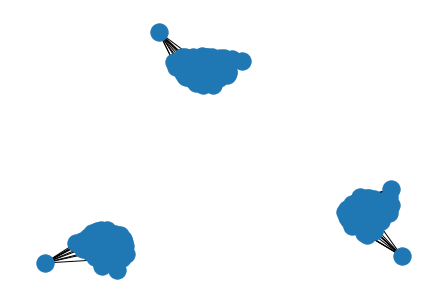

In [ ]:
# plot contact network G using nx.draw()

nc  = nx.draw(G,pos=nx.spring_layout(G))

# display figure using plt.show()

plt.show()


## Step 2 - Infection Rate

This milestone requires to determine the infection rate using the contact network obtained when completing Milestone 1. The infection rate is the total number of individuals with a confirmed infection, infection status `"y"`, divided by the total number of individuals in the contact networks. 

In [ ]:
# set variable "nriters" to 30
nriters=30

# create numpy array `W_MH` of shape (nrnodes,nrnodes) and with all entries zero

W_MH = np.zeros((nrnodes,nrnodes)) 

# loop over all edges in G.edges ()  

for edge in G.edges(): 
    # store first node of this edge in variable "node_a"
    node_a = edge[0]
    # store second node of this edge in variable "node_b"
    node_b = edge[1]
    # set entry W_MH[node_a,node_b] and W_MH[node_b,node_a] to MH weight  
    W_MH[node_a,node_b] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)
    W_MH[node_b,node_a] = 1/(np.max([G.degree(node_a),G.degree(node_b)])+1)

# loop over all nodes in the contact network G
for nodedmy in G.nodes(): 
    # set weights W[nodedmy,nodedmy] to 1 - sum of weights for all neighbors of nodedmy
    W_MH[nodedmy,nodedmy] = 1-np.sum(W_MH[nodedmy,:])
   
# loop over iterations for computing average infection rates

for iterdmy in range(nriters):
    # read in current values of "Rate" attributes into numpy array `graphsigold`
    graphsigold = np.fromiter(nx.get_node_attributes(G,'Rate').values(),dtype=float, count=nrnodes)
    
    # loop over all nodes in "G", use loop variable "node_i"
    for node_i in G.nodes(data=False):
        # set auxiliary variable "tmp" to 0 
        dmy = 0 
        # loop over all neighbours of current node "node_i"
        for node_j in G[node_i]: 
             dmy = dmy+W_MH[node_i,node_j]*graphsigold[node_j]#/(fac1*fac2)
        G.nodes[node_i]['Rate'] =W_MH[node_i,node_i]*graphsigold[node_i] + dmy
    


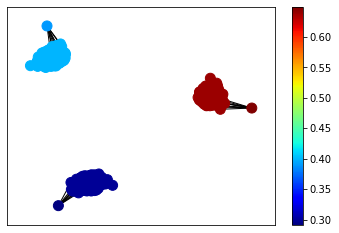

In [ ]:
# create a NodeView object "nodes" for the nodes in the networkx graph "G" 
nodes = G.nodes()

# create a list of "Rate" attribute for all nodes in "G"

list_of_rates = [G.nodes[node_i]['Rate'] for node_i in nodes]

# create coordinates of nodes in figure using nx.spring_layout(G) 

pos = nx.spring_layout(G)

# draw edges of "G" using nx.draw_networkx_edges() 

ec  = nx.draw_networkx_edges(G, pos)

# use nx.draw_networkx_nodes() to draw nodes of "G" using node colours given by "Rate" value for each node

nc  = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=list_of_rates, 
                            label=None, node_size=100, cmap=plt.cm.jet)

# add colorbar using plt.colorbar(); this needs as parameter the object returned by the above nx.draw_networkx_nodes()
plt.colorbar(nc)

# display figure using plt.show()

plt.show()